In [1]:
%load_ext tensorboard

import torch
from torch import nn
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms as T
import timm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adapted from https://github.com/tjmoon0104/pytorch-tiny-imagenet/blob/master/AlexNet.ipynb
data_transforms = {
    'train': T.Compose([
        T.Resize(299), T.ToTensor(),
    ]),
    'val': T.Compose([
        T.Resize(299), T.ToTensor(),
    ]),
    'test': T.Compose([
        T.Resize(299), T.ToTensor(),
    ])
}

data_dir = "C:\\Users\\Gabriel\\Documents\\Winter2022\\CIS472\\Project\\tiny-imagenet-200"
num_workers = {
    'train' : 4,
    'val'   : 0,
    'test'  : 0
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                                             num_workers=num_workers[x], shuffle=True)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [3]:
#
# Adapted from Stephen's ModelExamples
#
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
train = dataloaders["train"]

dataiter = iter(train)
imgs, labels = next(dataiter)
#img_grid = torchvision.utils.make_grid(imgs)
imgs, labels = imgs.to(device), labels.to(device)
#matplotlib_imshow(img_grid)

In [47]:
# Credit https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.empty(tensor.size(), device=device).normal_() * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    

class RobustInception(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        # Modify the last fully connected layer
        bare_inception = torchvision.models.inception_v3(pretrained=True, aux_logits=False)
        for param in bare_inception.parameters():
            param.requires_grad = False
        bare_inception.fc = nn.Linear(2048, 200)
        # Incoporate in model, probability softmax incorportated into loss
        self.inception = nn.Sequential(
            bare_inception,
            nn.Sigmoid()
        )
        self.perturb = AddGaussianNoise(0, 0.04)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return torch.cat((self.inception(x), self.inception(self.perturb(x))), 1)

In [36]:
ALPHA = 0.01

training_objective = nn.CrossEntropyLoss()

stability_loss = nn.CrossEntropyLoss()

def full_loss(outputs, label):
    clean_output, distort_output = torch.split(outputs, 200, 1)
    return training_objective(clean_output, label) + ALPHA * stability_loss(distort_output, clean_output)

In [48]:
model = RobustInception().to(device)

In [49]:
from torch import optim
from tqdm import tqdm # This is optional but useful

# Let's set up some parameters
learning_rate=0.01
momentum=0.9
nepochs = 1

# We need an optimizer that tells us what form of gradient descent to do
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# We also need a loss function
LossFunction = full_loss

# This is default on but let's just be pedantic
model.train()
loss_history = []
loss = torch.Tensor([0])
cnt = 0
for epoch in tqdm(range(nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    for (data, label) in tqdm(train,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True) # Here we clear the gradients
        
        # We need to make sure the tensors are on the same device as our model
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        
        loss = LossFunction(out, label)
        
        # PyTorch is Magic!
        loss.backward() # This function calculates all our gradients
        optimizer.step() # This function does our gradient descent with those gradients
        loss_history.append(loss.item())
        cnt += 1
        print(f"\r{cnt:3}/{len(train)}", end="")
        if cnt == 15:
            break
    print(f"\nEpoch {epoch}: loss: {loss.item()}")

Epoch:   0%|                                                                                  | 0/1 [00:00<?, ?epoch/s]

 15/391

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.28s/epoch]


Epoch 0: loss: 7.296338081359863


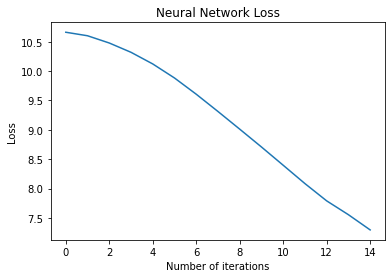

In [51]:
# Note that we are not plotting loss per epoch but per iteration
plt.plot(loss_history)
plt.title("Neural Network Loss")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

In [45]:
#list(model.parameters())[-3:]
#optimizer.state.values()
training_objective(torch.split(out, 200, 1)[1], label)
#stability_loss(torch.split(out, 200, 1)[1], torch.split(out, 200, 1)[0])

tensor(1.1672e+09, device='cuda:0', grad_fn=<NllLossBackward0>)

In [46]:
torch.split(out, 200, 1)[1]

tensor([[-91006096., -91006096., -91005536.,  ..., -91006152., -91006152.,
         -91004984.],
        [-62418420., -62418420., -62418252.,  ..., -62418436., -62418436.,
         -62418108.],
        [-89301576., -89301576., -89301192.,  ..., -89301576., -89301576.,
         -89301000.],
        ...,
        [-85520720., -85520720., -85520296.,  ..., -85520720., -85520720.,
         -85520088.],
        [-84133248., -84133296., -84132800.,  ..., -84133344., -84133344.,
         -84132600.],
        [-74545936., -74545968., -74545800.,  ..., -74545968., -74545968.,
         -74545168.]], device='cuda:0', grad_fn=<SplitBackward0>)

In [ ]:
validation = dataloaders["val"]
for data, label in validation:
    data = data.to(device)
    labels = labels.to(device)
    out = model(data)
    print(torch.sum(torch.split(out, 200, 1)[0].topk(1, dim=1)[1].t().flatten() == labels) / len(out))

In [83]:
len(out)

256